In [63]:
import eli5
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from joblib import dump
from sklearn.model_selection import cross_val_predict
from sklearn_crfsuite import CRF
from sklearn_crfsuite.metrics import flat_accuracy_score

from crf_extraction.utils.CRFClassifier import CRFClassifier
from crf_extraction.utils.features_functions import sent_to_features, sent_to_labels
from utils.DrugRecords import DrugRecords
from utils.data_functions import get_data

In [76]:
TRAINING_DATASET_PATH = "../datasets/train_dataset.csv"
VALIDATION_DATASET_PATH = "../datasets/validation_dataset.csv"
TEST_DATASET_PATH = "../datasets/test_dataset.csv"
JOBLIB_NAME_PATH = 'trained.joblib'

In [35]:
training_data = get_data(TRAINING_DATASET_PATH)
training_data.tail(5)

,Drug: #,Word,Tag
1350799,Drug: 122674,inj,FORM
1350800,Drug: 122674,.,FORM
1350801,Drug: 122674,væske,FORM
1350802,Drug: 122674,",",FORM
1350803,Drug: 122674,opløsning,FORM


In [36]:
train_drug_records = DrugRecords(training_data).get_drug_records()
train_drug_records = train_drug_records[1:] # without header

In [37]:
x_train = [sent_to_features(s) for s in train_drug_records]
y_train = [sent_to_labels(s) for s in train_drug_records]

In [77]:
crf_classifier = CRFClassifier(c1=0, c2=1, max_iterations=1, all_possible_transitions=False)
crf = crf_classifier.get_crf_classifier().fit(x_train, y_train)
crf

AttributeError: 'tuple' object has no attribute 'lower'

In [78]:
%%time

crf = CRF(c1=0, c2=1, max_iterations=1, all_possible_transitions=False)

crf.fit(x_train, y_train)
dump(crf, JOBLIB_NAME_PATH)

CPU times: user 12.2 s, sys: 60.4 ms, total: 12.3 s
Wall time: 12.3 s


/home/michaela/PycharmProjects/master-thesis/venv/lib/python3.7/site-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


CRF(all_possible_transitions=False, c1=0, c2=1, keep_tempfiles=None,
    max_iterations=1)

In [59]:
y_pred = cross_val_predict(estimator=crf, X=x_train, y=y_train, cv=5)

/home/michaela/PycharmProjects/master-thesis/venv/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=None as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/home/michaela/PycharmProjects/master-thesis/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


'              precision    recall  f1-score   support\n\n        FORM     0.0000    0.0000    0.0000    315393\n        NAME     0.0000    0.0000    0.0000    200614\n           O     0.0000    0.0000    0.0000     84099\n        PACK     0.0000    0.0000    0.0000    309006\n    STRENGTH     0.3270    1.0000    0.4928    441682\n\n    accuracy                         0.3270   1350794\n   macro avg     0.0654    0.2000    0.0986   1350794\nweighted avg     0.1069    0.3270    0.1611   1350794\n'

In [ ]:
acc_score = flat_accuracy_score(y_pred, y_train)
print(acc_score)

In [65]:
eli5.show_weights(crf, top=20)


/home/michaela/PycharmProjects/master-thesis/venv/lib/python3.7/site-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


In [66]:
validation_data = get_data(VALIDATION_DATASET_PATH)
validation_data.tail(5)

validation_drug_records = DrugRecords(validation_data).get_drug_records()
validation_drug_records = validation_drug_records[1:]


x_val = [sent_to_features(s) for s in validation_drug_records]
y_val = [sent_to_labels(s) for s in validation_drug_records]

In [69]:
predicted_values = crf.predict(x_val)
acc_score = flat_accuracy_score(predicted_values, y_val)
print(acc_score)

0.32577679797013437


In [73]:

y_pred = pd.Series([p for pred_val in predicted_values for p in pred_val])
y_true = pd.Series([w[1] for drug_record in validation_drug_records for w in drug_record])

a = pd.crosstab(y_true, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)
print(a)


Predicted  STRENGTH     All
True                       
FORM          39294   39294
NAME          24784   24784
O             10584   10584
PACK          38801   38801
STRENGTH      54824   54824
All          168287  168287


In [81]:

p = pd.crosstab(y_true, y_pred, rownames=['True'], colnames=['Predicted'], normalize="index").round(6)*100

print(p)


Predicted  STRENGTH
True               
FORM          100.0
NAME          100.0
O             100.0
PACK          100.0
STRENGTH      100.0


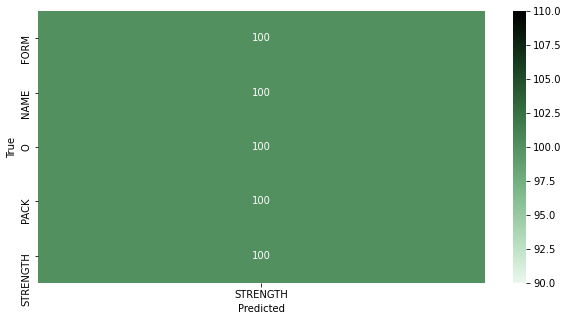

In [80]:
plt.figure(figsize=(10, 5))
sns_plot_percentage = sns.heatmap(p,
                       annot=True,
                       fmt='.4g',
                       cmap=sns.cubehelix_palette(200, start=2, rot=0, dark=0, light=.95, reverse=False)
)

sns_plot_percentage.figure.savefig("firstCrfModelMatrixPercentage.png")


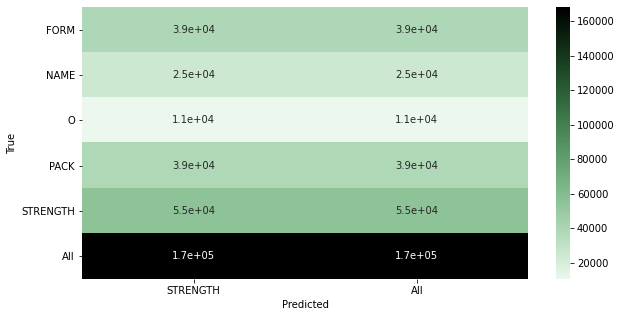

In [75]:
plt.figure(figsize=(10, 5))
sns_plot_values = sns.heatmap(a, annot=True, cmap=sns.cubehelix_palette(200, start=2, rot=0, dark=0, light=.95, reverse=False))

sns_plot_values.figure.savefig("firstCrfModelMatrixValues.png")
